# Optimization (aka operations research) problems

## Why would I need linear / integer optimization?

Business processes in the world are still very linear:
* Revenues and costs usually scale linearly (costs = fixed costs + variable costs $\times$ volume)
* Decisions are usually binary (give / not give credit)
* Logistics, supply chains, inventories are linear entities

Quadratic problems (as found eg. in investing) can also be solved effectively by most libraries

Non-linear processes can often be linearized ("perturbed")
* Anyone who took first-year Physics in university can relate to that 

# Getting started

In [1]:
# python -m pip install pulp
import pulp as pp

In [2]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Warm-up: a linear problem 

Every linear problem can be written as follows. Let $x_1,\ldots, x_n$ be our decision variables. Find them in order to

$$\boxed{\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle\sum\limits_{i=1}^{n} w_{i} x_{i} &\\
\text{subject to}& \displaystyle\sum\limits_{j=1}^{n} A_{ij} x_{j} \leq 0,  &i=1 ,\dots, m\\
                 & x_{i} \geq 0, &i=1 ,\dots, n
\end{array}}
$$

(there are $n$ decision variables and $m$ constraints) or, in matrix form (understanding that $x \geq a$ means $x_i \geq a_i$, ie. element-wise inequalities)

$$\boxed{\begin{array}{ll@{}ll}
\text{minimize}  & w^T x &\\
\text{subject to}& A x \leq b \\
                 & x \geq 0
\end{array}}
$$

Some (rather obvious) notes:
* A maximization problem can be written as the negative of a minimization problem
* All inequalities can similarly be shifted by changing signs

### Example (taken verbatim from Wikipedia):
> A farmer has a farm with $L$ km$^2$ to plant with some combination of wheat and barley. He has an amount $F$ of fertilizer (in kg) and $P$ in pesticide (also in kg). Every square kilometer *of wheat* requires an amount $F_1$ of fertilizer and $P_1$ of pesticide; every square kilometer *of barley* requires analogous amounts $F_2$ and $P_2$. Finally, wheat sells for $S_1$ dollars per km$^2$ and barley sells for $S_2$ dollars per km$^2$. What are the proportion of areas of wheat and barley that will maximize profits?

Solution:

We need some decision variables. Let $x_1$ denote the amount of wheat area to plant, and similarly let $x_2$ denote the area of barley. 
> Clearly $x_1 + x_2 \leq L$. This is a constraint.

Let us study our goals and constraints:
* Our total revenues are $x_1 S_1 + x_2 S_2$. This is what we want to maximize;
* We have constraints on the total amount of fertilizer and pesticide: we need $x_1 F_1$ and $x_1 P_1$ for wheat, and analogously for barley. Hence, we have a constraint for fertilizers

$$x_1 F_1 + x_2 F_2 \leq F$$
and one for pesticides:

$$x_1 P_1 + x_2 P_2 \leq P$$
* Finally, an obvious constraint is that we plant a positive amount of both:
$$x_1 \geq 0, \quad x_2 \geq 0$$

We can then write this in the standard form as

$$\begin{array}{ll@{}ll}
\text{minimize}  & -(x_1 S_1 + x_2 S_2) &\\
\text{subject to}& x_1 + x_2 &\leq L\\
                 & x_1 F_1 + x_2 F_2 &\leq F\\
                 & x_1 P_1 + x_2 P_2 &\leq P\\
                 & x_1\geq 0, \quad x_2 \geq 0
\end{array}
$$

or, in matrix form,

$$\begin{array}{ll@{}ll}
\text{minimize}  & w^T x &\\
\text{subject to}& A x \leq b \\
                 & x \geq 0
\end{array} \qquad \mbox{where}\qquad
\begin{align*}
x &= [x_1 \;\; x_2]^T\\
w &= [-S_1\;\; -S_2]^T\\
A &= \begin{bmatrix}
1 & 1 \\
F_1 & F_2 \\
P_1 & P_2
\end{bmatrix}, \quad
b = [L\;\; F \;\; P]^T
\end{align*}
$$

### Solving this with PuLP:

Any PuLP program is divided into 6 parts:
1. Build decision variables
2. Build support objects ($w, A, b$)
3. Construct the problem object
4. Construct objective function
5. Construct constraints
6. Solve

Let us assume the following values for the constants:

* $S_1 = 10,000,\quad S_2 = 9,000$ (dollars/km$^2$)
* $L = 100$ (km$^2$)
* $F = 200,000$ (kg), with $F_1 = 5,000$ and $F_2 = 4,000$
* $P = 100,000$ (kg), with $P_1 = 2,000$ and $P_2 = 6,000$

In [3]:
S1 = 10_000
S2 = 9_000
L  = 100
F  = 200_000 
F1 = 5_000
F2 = 4_000
P  = 100_000 
P1 = 2_000
P2 = 6_000

1. Decision variables 

In [4]:
x1 = pp.LpVariable('x1', lowBound=0)
x2 = pp.LpVariable('x2', lowBound=0)

2. Support variables: here, we can just hard-code; later we'll improve how to code this
3. Construct the problem object

In [5]:
prob = pp.LpProblem(name="farm", sense=pp.LpMaximize) # we can choose to maximize

4. Construct the objective function

In [6]:
prob += S1*x1 + S2*x2

5. Construct constraints

In [7]:
prob += x1+x2 <= L          # Area constraint
prob += F1*x1 + F2*x2 <= F  # Fertilizer constraint
prob += P1*x1 + P2*x2 <= P  # Pesticide constraint

Also, print the problem to see exactly what we are solving!

In [8]:
print(prob)

farm:
MAXIMIZE
10000*x1 + 9000*x2 + 0
SUBJECT TO
_C1: x1 + x2 <= 100

_C2: 5000 x1 + 4000 x2 <= 200000

_C3: 2000 x1 + 6000 x2 <= 100000

VARIABLES
x1 Continuous
x2 Continuous



6. Solve

In [9]:
status = prob.solve()       # solve using the default solver
print(pp.LpStatus[status])  # print the human-readable status

Optimal


Print variables:

In [10]:
print("x1:", pp.value(x1)) # 400/11
print("x2:", pp.value(x2)) # 50/11

x1: 36.363636
x2: 4.5454545


## Does this make sense? Sanity check -- In 2D, we can actually plot the constraints!

In [11]:
x1_ = np.linspace(0,100)

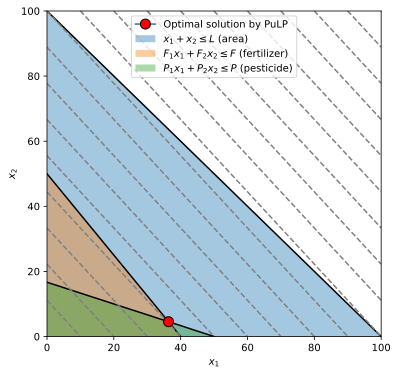

In [12]:
plt.subplots(figsize=(6,6))
plt.plot(x1_, L-x1_, color='black')
plt.fill_between(x1_, L-x1_, alpha=0.4, label="$x_1+x_2 \leq L$ (area)")
plt.plot(x1_, (F-F1*x1_)/F2, color='black')
plt.fill_between(x1_, (F-F1*x1_)/F2, alpha=0.4, label="$F_1 x_1+ F_2 x_2 \leq F$ (fertilizer)")
plt.plot(x1_, (P-P1*x1_)/P2, color='black')
plt.fill_between(x1_, (P-P1*x1_)/P2, alpha=0.4, label="$P_1 x_1+ P_2 x_2 \leq P$ (pesticide)")

# objective function
for c in np.linspace(0, (S1+S2)*L, 20):
    plt.plot(x1_, (c-S1*x1_)/S2, linestyle='--', color='gray')

# optimal solution
plt.plot(pp.value(x1), pp.value(x2), marker="o", markersize=10, markeredgecolor="black",
         markerfacecolor="red", label='Optimal solution by PuLP')

plt.legend()
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.show()

We see that the optimal point is exactly one satisfying all constraints, attaining the higher value of the objective function. It makes sense.

# Mixed integer programming (MIP)

Mixed integer programming adds decision variables which can take **discrete values**.

## Prototypical problem: knapsack problem ("problema da mochila")


We have $n$ product categories we want to bring from the US to Brazil to sell to our friends.

However, we can only take one $W = 23$ kg suitcase with us. Each product weights $w_i$ kg, and we can sell them for a price $s_i$.

> Question: what is the optimal set of products to bring, in order to maximize our profits but within the weight constraint?

The typical formulation is:

$$\begin{array}{ll@{}ll}
\text{maximize}  & \displaystyle\sum\limits_{i=1}^{n} s_{i} x_{i} &\\
\text{subject to}& \displaystyle\sum\limits_{i=1}^{n} w_i x_{i} \leq W\\
                 & x_{i} \in \{0, 1, 2, \ldots\}, &i=1 ,\dots, n
\end{array}
$$

Notice that now our $x_i$'s take integer values!

In [13]:
products = ['perfume', 'jeans', 'headphones', 'shoes']
weights  = [0.3, 1.0, 0.4, 1.5] # in kg
prices   = [500, 350, 800, 450] # in R$

In [14]:
# create vector variable, indexed by the product names
x = pp.LpVariable.dicts('x', indices=products, lowBound=0, cat='Integer')
x

{'perfume': x_perfume,
 'jeans': x_jeans,
 'headphones': x_headphones,
 'shoes': x_shoes}

In [15]:
# problem
prob = pp.LpProblem(name='muamba', sense=pp.LpMaximize)

# objective
prob += pp.lpSum([p * x[index] for p, index in zip(prices, products)])

In [16]:
# weight constraint
prob += pp.lpSum([w * x[index] for w, index in zip(weights, products)]) <= 23 

# check if correct
prob

muamba:
MAXIMIZE
800*x_headphones + 350*x_jeans + 500*x_perfume + 450*x_shoes + 0
SUBJECT TO
_C1: 0.4 x_headphones + x_jeans + 0.3 x_perfume + 1.5 x_shoes <= 23

VARIABLES
0 <= x_headphones Integer
0 <= x_jeans Integer
0 <= x_perfume Integer
0 <= x_shoes Integer

In [17]:
# solve
status = prob.solve()      
print(pp.LpStatus[status]) 

Optimal


In [18]:
for name, value in x.items():
    print(name+":", pp.value(value))

perfume: 2.0
jeans: 0.0
headphones: 56.0
shoes: 0.0


Our model says we should bring **2 bottles of perfume** and **56 headphones**. Let us make sure this obeys the weight constraints:

In [19]:
print("Total weight:", round(2*0.3 + 56*0.4, 0))

Total weight: 23.0


What is our expected revenue?

In [20]:
print("Total revenue: R$", round(2*500 + 56*800, 0))

Total revenue: R$ 45800


# Traveling salesman problem

This is also a classic problem in integer optimization. 

Consider a salesman who needs to go to $N$ cities. He must go to all of them, but the order doesn't matter.

However, he doesn't have an infinite budget, and needs to find the **cheapest route** in order to go to all of them:

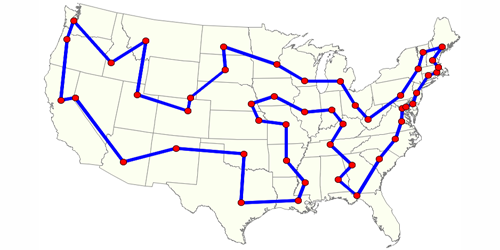

Formally, let $I$ be a set denoting all of the cities, with $|I|=N$. 

Let $c_{ij} > 0$ be the cost of going from city $i$ to $j$ or vice-versa (ie. $c_{ij} = c_{ji}$).


How can we model this as an optimization problem? **What should the decision variables be?**

We let 
$$x_{ij} = \begin{cases} 
1 & \mbox{ if the path $i\to j$ is included in his route}\\
0 & \mbox{otherwise}
\end{cases}$$

Then the total cost the salesman incurs in his trip is

$$\sum_{i=1}^N \sum_{j=1}^N c_{ij} x_{ij}$$

Are there any constraints? Yes (otherwise, the solution would be the trivial $x_{ij} \equiv 0$ for all $i,j$). He must visit each city *ondde and only once*. In other words, for a given city $i$, there must exist *one* another city $j \neq i$ such that $x_{ji} = 1$ (ie he goes from $j$ to $i$)

Furthermore, if he visits a city $i$, he must leave it at some point too, so there must exist some $k \neq i$ such that $x_{ik} = 1$ too.

We can encompass these two constraints mathematically as: for all $i$,

$$\sum_{j=1, j\neq i}^N x_{ji} = 1 \qquad \mbox{(he gets to city $i$ from somewhere)} $$
$$\sum_{j=1, j\neq i}^N x_{ij} = 1 \qquad \mbox{(he goes from city $i$ to somewhere)} $$

The first one of these **ensures** that one such $x_{ij}$ will be one while all the others are zero, and analogously for the second equation.

Let's try to solve this.

In [21]:
def generate_random_points(n: int, random_seed=1):
    np.random.seed(random_seed)
    points = np.random.rand(n,2)
    x, y = points[:,0], points[:,1]
    return x, y

from scipy.linalg import norm
dist = lambda x, y: norm(x-y)

In [22]:
points_x, points_y = generate_random_points(16, random_seed=10)

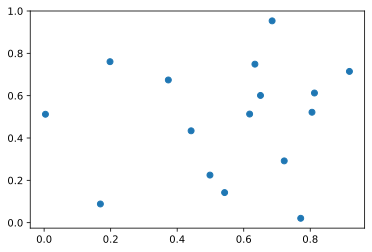

In [23]:
plt.scatter(points_x, points_y); plt.show()

### Build object containing points

In [24]:
from itertools import product

In [25]:
points = {i: np.array([xx,yy]) for i, (xx,yy) in enumerate(zip(points_x,points_y))}
point_indices = sorted(points.keys())

indices = [(i,j) for i, j in product(point_indices, point_indices) if i != j]

In [26]:
points

{0: array([0.77132064, 0.02075195]),
 1: array([0.63364823, 0.74880388]),
 2: array([0.49850701, 0.22479665]),
 3: array([0.19806286, 0.76053071]),
 4: array([0.16911084, 0.08833981]),
 5: array([0.68535982, 0.95339335]),
 6: array([0.00394827, 0.51219226]),
 7: array([0.81262096, 0.61252607]),
 8: array([0.72175532, 0.29187607]),
 9: array([0.91777412, 0.71457578]),
 10: array([0.54254437, 0.14217005]),
 11: array([0.37334076, 0.67413362]),
 12: array([0.44183317, 0.43401399]),
 13: array([0.61776698, 0.51313824]),
 14: array([0.65039718, 0.60103895]),
 15: array([0.8052232 , 0.52164715])}

### Build costs = distances

In [27]:
d = {}
for i, pi in points.items():
    for j, pj in points.items():
        if i !=j:
            d[(i,j)] = dist(pi, pj)

### Start PuLP program

In [28]:
# create decision variables xij in {0,1}
x = pp.LpVariable.dicts('x', indices=indices, lowBound=0, upBound=1, cat='Integer')

# problem
salesman = pp.LpProblem('traveling_salesman', sense=pp.LpMinimize) # minimization problem

# objective function sum(c_ij x_ij)
salesman += pp.lpSum([d[index] * x[index] for index in indices])

# constraints
for i in point_indices:
    salesman += pp.lpSum([x[(i, j)] for j in point_indices if j != i]) == 1

for i in point_indices:
    salesman += pp.lpSum([x[(j, i)] for j in point_indices if j != i]) == 1
    
# solve
status = salesman.solve()      
print(pp.LpStatus[status]) 

Optimal


In [29]:
def plot_solution_salesman(x, points_x, points_y, dist_dict):
    dist = 0
    for key, value in x.items():
        if pp.value(value) == 1:
            a = key[0]
            b = key[1]

            x1, x2 = points_x[a], points_x[b]
            y1, y2 = points_y[a], points_y[b]

            plt.plot([x1,x2],[y1,y2], color='black')
            dist += dist_dict[(a,b)]
    print("Total distance:", round(dist,3))
    plt.scatter(points_x, points_y)
    plt.show()

Total distance: 3.465


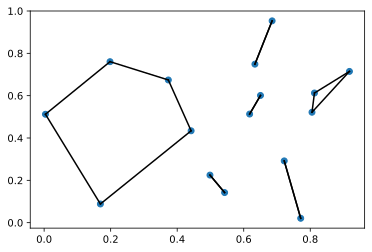

In [30]:
plot_solution_salesman(x, points_x, points_y, d)

Hm... this doesn't look right. We have created multiple subgroups, requiring our salesman to teleport.

**We need more constraints** - to ensure there are no disconnected subsets.

The so-called Dantzig–Fulkerson–Johnson formulation adds the following constraint:

For every subset $Q$ of indices $\{1,\ldots,N\}$ with at least two indices (ie. $|Q| \geq 2$), we set

$$\sum_{i\in Q} \sum_{j\neq i, j\in Q} x_{ij} \leq |Q| - 1$$

### TODO: Add interpretation

In [31]:
def powerset(iterable):
    from itertools import chain, combinations
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [32]:
%%time
# create decision variables xij in {0,1}
x = pp.LpVariable.dicts('x', indices=indices, lowBound=0, upBound=1, cat='Integer')

# problem
salesman = pp.LpProblem('traveling_salesman', sense=pp.LpMinimize) # minimization problem

# objective function sum(c_ij x_ij)
salesman += pp.lpSum([d[index] * x[index] for index in indices])

print("Add constraints...")
# constraints
for i in point_indices:
    salesman += pp.lpSum([x[(i, j)] for j in point_indices if j != i]) == 1

for i in point_indices:
    salesman += pp.lpSum([x[(j, i)] for j in point_indices if j != i]) == 1

# new constraints on proper subsets
Q_list = [Q for Q in powerset(point_indices) if (len(Q) > 1) & (len(Q) < len(point_indices))]
print("  > New constraints to add: ", len(Q_list))

for Q in tqdm(Q_list):
    salesman += pp.lpSum([x[(i,j)] for i, j in product(Q,Q) if i != j]) <= len(Q) - 1

print("Solving...")
status = salesman.solve()      
print("Solution is", pp.LpStatus[status]) 

Add constraints...
  > New constraints to add:  65518


  0%|          | 0/65518 [00:00<?, ?it/s]

Solving...
Solution is  Optimal
CPU times: user 19.4 s, sys: 1.19 s, total: 20.6 s
Wall time: 37.1 s


Total distance: 3.662


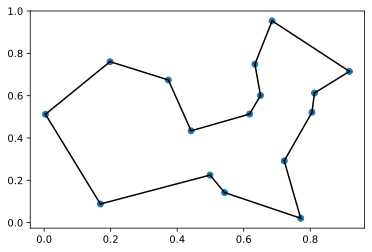

In [33]:
plot_solution_salesman(x, points_x, points_y, d)

# Real-life applied problem

We have 8 cities $\{C_i\}_{i=1}^8$ and 2 power plants $\{P_a\}_{a=1}^2$ in a given region.
* Every city has some demand $D_i$ for electricity (measured in kWh/month); 
* Each power plant can provide a total supply $S_a$ (also measured in kWh/month) of electricity

**Question**: How much energy should each power plant provide to each city?

Here, we must **assume** $\sum_a S_a \geq \sum_i D_i$, ie. the two plants can provide enough energy to all cities.

> If there are no other points, the solution is trivial: greedly assign a plant to a city until it fills the demand, and keep going randomly.

But what if we add some costs?

Considering the distances between cities and plants, we might consider a **variable cost matrix** like the one below (in units of dollar/kWh):

| |Plant 0|Plant 1|
|---|---|---|
|**City 0**|  0.5 | 0.8|
|**City 1**|  0.9 | 0.6|
|**City 2**|  1.2 | 1.5|
|**City 3**|  0.3 | 0.8|
|**City 4**|  0.4 | 0.6|
|**City 5**|  0.9 | 0.3|
|**City 6**|  0.2 | 0.6|
|**City 7**|  2.1 | 1.5|

We can go beyond: if a city decides to connect to a given plant, it must pay a **fixed amount** $F_{ai}$ to set-up the infrastructure:
<!-- 
| |Plant 0|Plant 1|
|---|---|---|
|**City 0**|  0.5 | 0.8|
|**City 1**|  0.9 | 0.6|
|**City 2**|  1.2 | 1.5|
|**City 3**|  0.3 | 0.8|
|**City 4**|  0.4 | 0.6|
|**City 5**|  0.9 | 0.3|
|**City 6**|  0.2 | 0.6|
|**City 7**|  2.1 | 1.5| -->

Now the problem becomes more interesting: how to get all the energy each city needs, but minimizing costs?

### Mathematical model

Let $x_{ai} \in \mathbb R$ be the amount of energy power plant $a$ provides to city $i$. Let us try to find what constraints need to be satisfied
* Clearly, $x_{ai} \geq 0$ for all $a$ and $i$
* Plants cannot provide more energy than they produce. In other words,
  $$\sum_{i=1}^8 x_{ai} \leq S_a\quad \mbox{for all $a$}$$ 
* A city needs to receive exactly the amount of energy it needs:
  $$\sum_{a=1}^2 x_{ai} = D_i\quad \mbox{for all $i$}$$

**What do we want to optimize for?** 
* The cost that a city pays for the energy they get is $$\sum_{a=1}^2 c_{ai} x_{ai};$$ hence, the total variable costs are
  $$\sum_{i=1}^8 \sum_{a=1}^2 c_{ai} x_{ai}$$

* Let $y_{ai} \in \{0,1\}$ be an indicator variable that is 1 if the city $i$ connects to plant $a$, and zero otherwise. Then, the total fixed costs are
  $$\sum_{i=1}^8 \sum_{a=1}^2 F_{ai} y_{ai}$$



**How do $x_{ai}$'s connect to $y_{ai}$?** We need something like $x_{ai} > 0 \Leftrightarrow y_{ai}= 1$. This is something like an indicator function; we are outside of the domain of linear programming.

Instead, we can use the **big-M trick**: let $M \gg 0$ be a large number. Consider the constraint

$$\boxed{x_{ai} \leq M y_{ai}}$$

Then $x_{ai} \equiv \epsilon \geq 0 \Rightarrow y_{ai} \geq \epsilon/M > 0 \Rightarrow y_{ai} = 1$, so indeed it works as an indicator variable. 

> More tricks: https://docs.mosek.com/modeling-cookbook/mio.html

Our formulation then becomes:

$$\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle  \sum_{i=1}^8 \sum_{a=1}^2 [c_{ai} x_{ai} +F_{ai} y_{ai}] \\
\text{subject to}& \displaystyle \sum_{i=1}^8 x_{ai} \leq S_a &\mbox{for all $a$ (supply constraint)}\\
                 & \displaystyle \sum_{a=1}^2 x_{ai} \geq D_i & \mbox{for all $i$ (demand constraint)}\\
                 & x_{ai} \leq M y_{ai} & \mbox{for all $i,a$ (big-M constraint)}\\
                 & x_{ai} \geq 0 & \mbox{for all $i,a$}\\
                 & y_{ai} \in \{0,1\}& \mbox{for all $i,a$}
\end{array}
$$

Setting up the problem:

In [59]:
cities = [f'City{i}' for i in range(8)]
plants = [f'Plant{a}' for a in range(2)]

var_costs = {('Plant0', 'City0'): 0.5,
             ('Plant0', 'City1'): 0.9,
             ('Plant0', 'City2'): 1.2,
             ('Plant0', 'City3'): 0.3,
             ('Plant0', 'City4'): 0.4,
             ('Plant0', 'City5'): 0.9,
             ('Plant0', 'City6'): 0.2,
             ('Plant0', 'City7'): 2.1,
             ('Plant1', 'City0'): 0.8,
             ('Plant1', 'City1'): 0.6,
             ('Plant1', 'City2'): 1.5,
             ('Plant1', 'City3'): 0.8,
             ('Plant1', 'City4'): 0.6,
             ('Plant1', 'City5'): 0.3,
             ('Plant1', 'City6'): 0.6,
             ('Plant1', 'City7'): 1.5}

fixed_costs = {('Plant0', 'City0'): 15_000,
               ('Plant0', 'City1'): 14_000,
               ('Plant0', 'City2'): 15_000,
               ('Plant0', 'City3'): 8_000,
               ('Plant0', 'City4'): 5_000,
               ('Plant0', 'City5'): 9_000,
               ('Plant0', 'City6'): 8_000,
               ('Plant0', 'City7'): 10_000,
               ('Plant1', 'City0'): 8_000,
               ('Plant1', 'City1'): 5_000,
               ('Plant1', 'City2'): 2_000,
               ('Plant1', 'City3'): 10_000,
               ('Plant1', 'City4'): 6_000,
               ('Plant1', 'City5'): 5_000,
               ('Plant1', 'City6'): 5_000,
               ('Plant1', 'City7'): 5_000}


demands = {'City0': 10_000,
           'City1': 15_000,
           'City2': 23_500,
           'City3': 12_400,
           'City4': 31_000,
           'City5': 28_000,
           'City6': 9_000,
           'City7': 17_000}

supplies = {'Plant0': 90_000,
            'Plant1': 55_900}

indices = list(product(plants, cities))

In [60]:
# create decision variables xij >= 0 and yij in {0,1}
x = pp.LpVariable.dicts('x', indices=indices, lowBound=0)
y = pp.LpVariable.dicts('y', indices=indices, lowBound=0, upBound=1, cat='Integer')

big_M = 100_000

# problem
energy = pp.LpProblem('energy_supply', sense=pp.LpMinimize) # minimization problem

# objective function 
energy += pp.lpSum([var_costs[index] * x[index] + fixed_costs[index] * y[index] for index in indices])

print("Add constraints...")
print("  > Supply:")
for a in plants:
    energy += pp.lpSum([x[(a,i)] for i in cities]) <= supplies[a]
    
print("  > Demand:")
for i in cities:
    energy += pp.lpSum([x[(a,i)] for a in plants]) >= demands[i]

print("  > Big-M:")
for index in indices:
    energy += x[index] <= big_M * y[index]

print("Solving...")
status = energy.solve()      
print("Solution is", pp.LpStatus[status])

Add constraints...
  > Supply:
  > Demand:
  > Big-M:
Solving...
Solution is Optimal


In [61]:
for key, value in x.items():
    print(key, ":", pp.value(value))

('Plant0', 'City0') : 10000.0
('Plant0', 'City1') : 0.0
('Plant0', 'City2') : 23500.0
('Plant0', 'City3') : 12400.0
('Plant0', 'City4') : 31000.0
('Plant0', 'City5') : 4100.0
('Plant0', 'City6') : 9000.0
('Plant0', 'City7') : 0.0
('Plant1', 'City0') : 0.0
('Plant1', 'City1') : 15000.0
('Plant1', 'City2') : 0.0
('Plant1', 'City3') : 0.0
('Plant1', 'City4') : 0.0
('Plant1', 'City5') : 23900.0
('Plant1', 'City6') : 0.0
('Plant1', 'City7') : 17000.0
